<a href="https://colab.research.google.com/github/Fahdlabba/Sentiment-Prediction-in-Tweets/blob/main/Sentiment_Prediction_in_Tweets_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d utkarshx27/sentiment-analysis

 96% 78.0M/81.0M [00:01<00:00, 48.0MB/s]
100% 81.0M/81.0M [00:01<00:00, 46.1MB/s]


In [4]:
from zipfile import ZipFile

with ZipFile("/content/sentiment-analysis.zip","r") as zip :
  zip.extractall()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [6]:
df=pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding="ISO-8859-1")

In [7]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#Data Preprocessing

In [8]:
df.shape

(1599999, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [10]:
df.drop(columns=["1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_"],axis=1,inplace=True)

In [11]:
df.head()

,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [12]:
df.rename(columns={"0":"label","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D":"tweet"},inplace=True)

In [13]:
df.head()

,label,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


<Axes: xlabel='label', ylabel='count'>

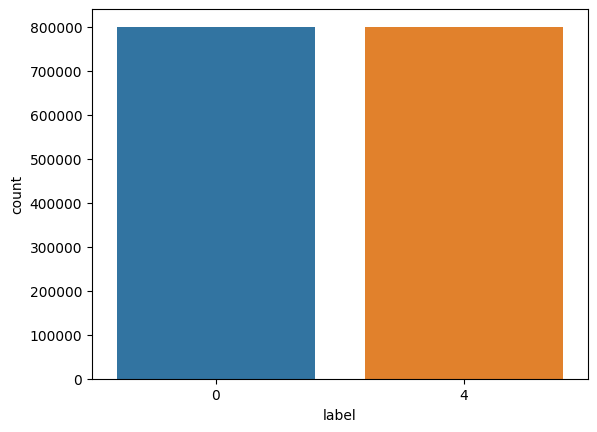

In [14]:
sns.countplot(x="label",data=df)

In [15]:
df["label"]=df["label"].map(lambda x :1 if (x==4) else 0 )

In [16]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [17]:
df.duplicated().sum()

16309

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df.shape

(1583690, 2)

In [20]:
X=df.drop(columns="label")
Y=df["label"]

In [21]:
X

,tweet
0,is upset that he can't update his Facebook by ...
1,@Kenichan I dived many times for the ball. Man...
2,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all...."
4,@Kwesidei not the whole crew
...,...
1599994,Just woke up. Having no school is the best fee...
1599995,TheWDB.com - Very cool to hear old Walt interv...
1599996,Are you ready for your MoJo Makeover? Ask me f...
1599997,Happy 38th Birthday to my boo of alll time!!! ...


In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
port_stem=PorterStemmer()
def stemming(content):
  stemmed_content=re.sub('[^a-zA-Z]',' ',content)
  stemmed_content=stemmed_content.lower()
  stemmed_content=stemmed_content.split()
  stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english') ]
  stemmed_content=' '.join(stemmed_content)
  return stemmed_content

In [25]:
X["tweet"]=X["tweet"].apply(stemming)

In [26]:
X.head()

,tweet
0,upset updat facebook text might cri result sch...
1,kenichan dive mani time ball manag save rest g...
2,whole bodi feel itchi like fire
3,nationwideclass behav mad see
4,kwesidei whole crew


In [27]:
vectorizer=TfidfVectorizer()
X=X["tweet"].values
X=vectorizer.fit_transform(X)

In [28]:
print(X)

  (0, 50970)	0.3728116702175915
  (0, 14528)	0.27899165699723183
  (0, 474893)	0.19252359102505157
  (0, 410935)	0.24811226425856123
  (0, 391097)	0.36360361877165087
  (0, 97384)	0.28890205180887835
  (0, 305666)	0.2822201043828242
  (0, 461680)	0.30804728015536365
  (0, 146672)	0.31528758673333385
  (0, 492070)	0.2857583569352021
  (0, 492307)	0.33656007330072935
  (1, 56815)	0.37403033924381074
  (1, 172873)	0.14223865170840028
  (1, 390987)	0.2677691844657738
  (1, 409248)	0.2864737099456002
  (1, 288877)	0.3020828230011402
  (1, 37288)	0.30903429798182774
  (1, 472107)	0.1709979211015341
  (1, 289556)	0.25139873639306254
  (1, 118801)	0.3929295647691386
  (1, 247512)	0.5025041918369199
  (2, 153090)	0.4615652415356577
  (2, 271004)	0.23965240163109378
  (2, 212152)	0.5511813708843215
  (2, 150236)	0.2690725744036411
  :	:
  (1583686, 347141)	0.20210998714260536
  (1583686, 209358)	0.25804181560191597
  (1583686, 93166)	0.1953069923516041
  (1583686, 186920)	0.2046284503317314
  (1

In [29]:
Y=Y.values

In [30]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

In [31]:
X_train.shape

(1266952, 532699)

#Naive Bayes : MultinomialNB

In [32]:
from sklearn.naive_bayes import MultinomialNB

In [33]:
model=MultinomialNB(alpha=1)

In [34]:
model.fit(X_train,Y_train)

MultinomialNB(alpha=1)

In [35]:
y_pre=model.predict(X_train)

In [46]:
from sklearn.metrics import accuracy_score , confusion_matrix,f1_score

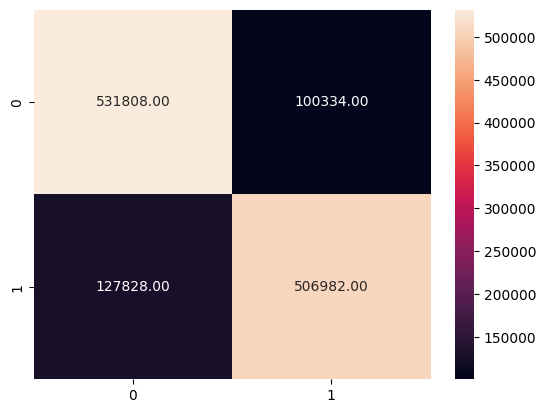

In [37]:
def confusion(Y,Y_hat):
  conf=confusion_matrix(Y,Y_hat)
  sns.heatmap(conf,cbar=True,fmt='.2f',annot=True)
confusion(Y_train,y_pre)

In [39]:
y_p=model.predict(X_test)

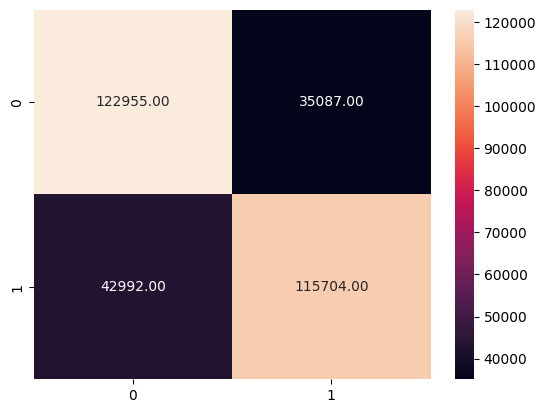

In [40]:
confusion(Y_test,y_p)

In [52]:
def metrics(y_train,y_test,y_hat,y_hat_):
  print(f"Train accuracy score : {accuracy_score(Y_train,y_hat)}")
  print(f"F1-score for training data : {f1_score(Y_train,y_hat)}")
  print(f"Test accuracy score : {accuracy_score(Y_test,y_hat_)}")
  print(f"F1-score for testing data : {f1_score(Y_test,y_hat_)}")

In [53]:
metrics(Y_train,Y_test,y_pre,y_p)

Train accuracy score : 0.8199126723032917
F1-score for training data : 0.8163133208708296
Test accuracy score : 0.7534902664031471
F1-score for testing data : 0.7477147666945623


#Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


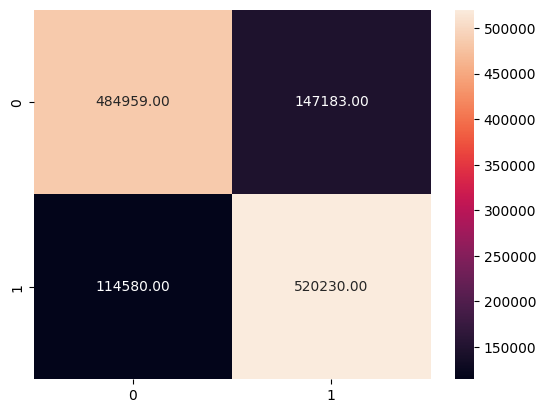

In [43]:
log_model=LogisticRegression()
log_model.fit(X_train,Y_train)
y_hat=log_model.predict(X_train)
confusion(Y_train,y_hat)

0.7748770277011284


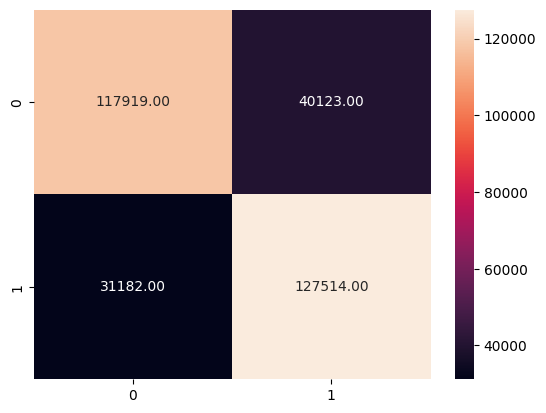

In [45]:
y_hat_test=log_model.predict(X_test)
confusion(Y_test,y_hat_test)

In [54]:
metrics(Y_train,Y_test,y_hat,y_hat_test)

Train accuracy score : 0.7933915412738605
F1-score for training data : 0.7989875773964981
Test accuracy score : 0.7748770277011284
F1-score for testing data : 0.7814962017325859


# Naive Bayes performs well on the training dataset, but Logistic Regression outperforms it on the testing dataset.